In [1]:
from pfd_toolkit import load_reports, LLM, Screener, Extractor
from pydantic import BaseModel, Field

In [2]:
reports = load_reports(end_date="2025-11-25",
                       refresh=True)

print(f"In total, there were {len(reports)} PFD reports published between July 2013 and 25th November 2025.")

In total, there were 6043 PFD reports published between July 2013 and 25th November 2025.


In [3]:
from dotenv import load_dotenv
import os

# Load OpenAI API key from local environment
load_dotenv("api.env")
openai_api_key = os.getenv("OPENAI_API_KEY")

# Initialise LLM client
llm_client = LLM(api_key=openai_api_key, 
                 max_workers=30, 
                 model="gpt-4.1-mini",
                 seed=123, 
                 temperature=0, 
                 timeout=60)

3982234 total tokens


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Report length distribution'}, xlabel='Tokens count', ylabel='Number of reports'>)

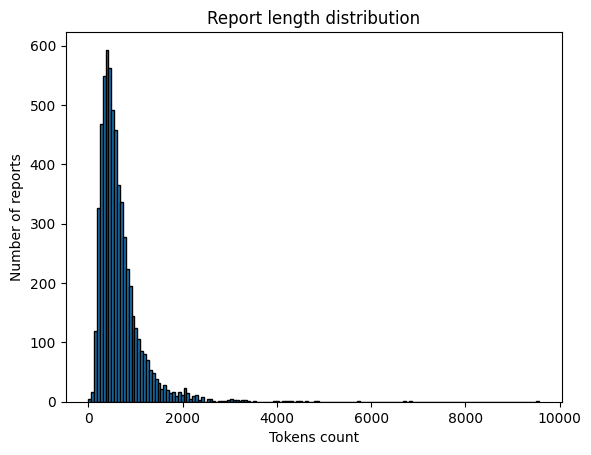

In [5]:
extractor = Extractor(llm=llm_client, reports=reports)

extractor.count(measure="tokens")

In [ ]:
# Set up Screener
search_query = "Suicide deaths."

second_search_query = """
Deaths where the coroner raised concerns related to the involvement (or lack of) of the deceased's 'significant other(s)' (e.g. the deceased's close friends or family).
"""

screener = Screener(llm=llm_client, reports=reports)

suicide_reports = screener.screen_reports(search_query=search_query)
suicide_sig_reports = screener.screen_reports(reports = suicide_reports, search_query=second_search_query)